In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [2]:
num_classes = 10

learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

conv1_filters = 32
conv2_filters = 64
fc1_units = 1024

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding = "SAME")
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return x

def maxpool2d(x, k = 2):
    x = tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = "SAME")
    return x

In [6]:
random_normal = tf.initializers.RandomNormal()

weights = {
    "wc1" : tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    "wc2" : tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    "wd1" : tf.Variable(random_normal([7 * 7 * 64, fc1_units])),
    "out" : tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    "bc1" : tf.Variable(tf.zeros([conv1_filters])),
    "bc2" : tf.Variable(tf.zeros([conv2_filters])),
    "bd1" : tf.Variable(tf.zeros([fc1_units])),
    "out" : tf.Variable(tf.zeros([num_classes]))
}

In [7]:
random_normal = tf.initializers.RandomNormal()

weights = {
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    'wd1': tf.Variable(random_normal([7*7*64, fc1_units])),
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [8]:
def conv_net(x):
    x = tf.reshape(x, [-1, 28, 28, 1])
    conv1 = conv2d(x, weights["wc1"], biases["bc1"])
    conv1 = maxpool2d(conv1, k = 2)
    conv2 = conv2d(conv1, weights["wc2"], biases["bc2"])
    conv2 = maxpool2d(conv2, k = 2)
    fc1 = tf.reshape(conv2, [-1, weights["wd1"].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights["wd1"]), biases["bd1"])
    fc1 = tf.nn.relu(fc1)
    out = tf.add(tf.matmul(fc1, weights["out"]), biases["out"])
    return tf.nn.softmax(out)

In [9]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth = num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis = -1)

optimizer = tf.optimizers.Adam(learning_rate)

In [10]:
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
        
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [11]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Step: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Step: 10, Loss: 66.014206, Accuracy: 0.835938
Step: 20, Loss: 30.751205, Accuracy: 0.906250
Step: 30, Loss: 28.928139, Accuracy: 0.960938
Step: 40, Loss: 12.829302, Accuracy: 0.976562
Step: 50, Loss: 18.306452, Accuracy: 0.968750
Step: 60, Loss: 15.243832, Accuracy: 0.945312
Step: 70, Loss: 18.980936, Accuracy: 0.945312
Step: 80, Loss: 15.422307, Accuracy: 0.968750
Step: 90, Loss: 10.089300, Accuracy: 0.984375
Step: 100, Loss: 10.800920, Accuracy: 0.992188
Step: 110, Loss: 4.265473, Accuracy: 1.000000
Step: 120, Loss: 15.453290, Accuracy: 0.960938
Step: 130, Loss: 16.010666, Accuracy: 0.960938
Step: 140, Loss: 6.198751, Accuracy: 0.992188
Step: 150, Loss: 5.054309, Accuracy: 0.984375
Step: 160, Loss: 3.800585, Accuracy: 1.000000
Step: 170, Loss: 2.666845, Accuracy: 1.000000
Step: 180, Loss: 6.986701, Accuracy: 0.992188
Step: 190, Loss: 12.192752, Accuracy: 0.976562
Step: 200, Loss: 4.097617, Accuracy: 1.000000


In [12]:
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.980700


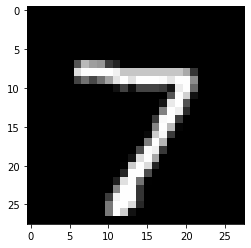

Model Prediction: 7


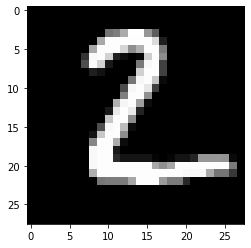

Model Prediction: 2


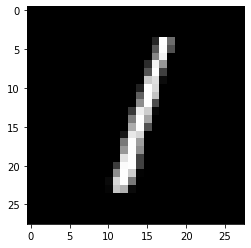

Model Prediction: 1


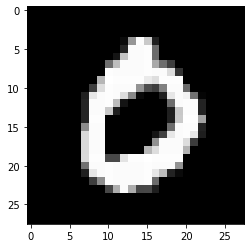

Model Prediction: 0


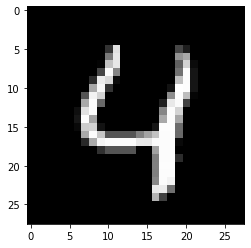

Model Prediction: 4


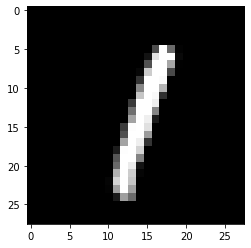

Model Prediction: 1


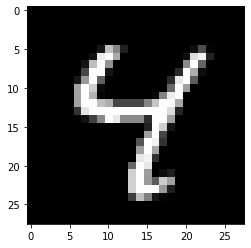

Model Prediction: 4


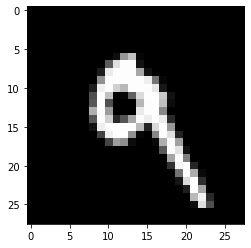

Model Prediction: 9


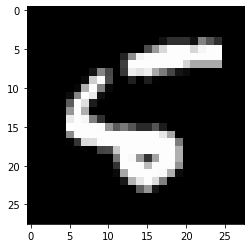

Model Prediction: 5


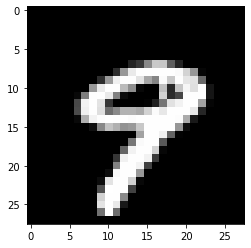

Model Prediction: 9


In [14]:
import matplotlib.pyplot as plt
n_images = 10
test_images = x_test[:n_images]
predictions = conv_net(test_images)

for idx in range(n_images):
    plt.imshow(np.reshape(test_images[idx], [28, 28]), cmap = 'gray')
    plt.show()
    print("Model Prediction: %i" % np.argmax(predictions.numpy()[idx]))